In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
from anndata import AnnData, read_h5ad
import anndata as ad
from scipy.stats import pearsonr, norm, ttest_ind, fisher_exact, kruskal, shapiro
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import nrrd
import matplotlib.pyplot as plt
from scipy import stats
import plotting_help_py37 as ph
import LR_assist as lr

In [3]:
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Expression

In [4]:
ORN = read_h5ad('ORN_all_annotated_GH.h5ad')
ORN_42h = ORN[(ORN.obs.stage == '42h')]
ORN_24h = ORN[(ORN.obs.stage == '24h')]
ORN_adult = ORN[(ORN.obs.stage == 'adult')]
PN = read_h5ad('adata_PN_all_annotated_2022update.h5ad')
PN_0h = PN[(PN.obs.stage == '0h')]
PN_24h = PN[(PN.obs.stage == '24h')]
PN_48h = PN[(PN.obs.stage == '48h')]
PN_adult = PN[(PN.obs.stage == 'adult')]
mm, _ = nrrd.read('OlfactoryGlomeruli_JFRC_python.nrrd')

seqss1 = ORN_42h
seqss2 = PN_24h
gloms1 = list(np.unique(lr.get_glomtypes_from_seqss(seqss1, datatype_orn=True)))
gloms2 = list(np.unique(lr.get_glomtypes_from_seqss(seqss2, datatype_orn=False)))
gloms_shared = list(set(gloms1).intersection(gloms2))
genes1 = list(seqss1.var_names)
genes2 = list(seqss2.var_names)
genes_shared = list(set(genes1).intersection(genes2))

RNA preference index

In [26]:
PN=PN_24h
ORN=ORN_24h
gene = 'kirre'
PN_gene1 = PN[:, (PN.var_names == gene)]
ORN_gene2 = ORN[:, (ORN.var_names == gene)]
PN_gene1_d = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == 'VA1d']
ORN_gene2_d = ORN_gene2[lr.get_glomtypes_from_seqss(ORN, True) == 'VA1d']
PN_gene1_v = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == 'VA1v']
ORN_gene2_v = ORN_gene2[lr.get_glomtypes_from_seqss(ORN, True) == 'VA1v']
PN_mean_d=np.nanmean(PN_gene1_d.X, axis=0)
ORN_mean_d=np.nanmean(ORN_gene2_d.X, axis=0)
PN_mean_v=np.nanmean(PN_gene1_v.X, axis=0)
ORN_mean_v=np.nanmean(ORN_gene2_v.X, axis=0)
PN_preference_index=(PN_mean_d-PN_mean_v)/(PN_mean_d+PN_mean_v)
ORN_preference_index=(ORN_mean_d-ORN_mean_v)/(ORN_mean_d+ORN_mean_v)

In [27]:
A = [PN_preference_index, ORN_preference_index]
A

[ArrayView([-0.0069587], dtype=float32),
 ArrayView([-0.05374074], dtype=float32)]

Plot for expression throughout the Antennal lobe

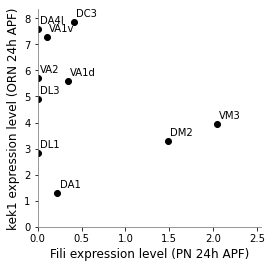

In [11]:
PN=PN_24h
ORN=ORN_24h
time = ['PN 24h APF','ORN 24h APF']
gene1='Fili'
gene2='kek1'
glom_list=gloms_shared
datatype_orn= [False,True]

fig, ax = plt.subplots(figsize =(4, 4)) 

# calculate gene expression in each glom
PN_gene1 = PN[:, (PN.var_names == gene1)]
ORN_gene2 = ORN[:, (ORN.var_names == gene2)]
PN_gene1_mean = []
ORN_gene2_mean = []
glom_list_new = []
for glom_ in glom_list:
    PN_gene1_glom = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    ORN_gene2_glom = ORN_gene2[lr.get_glomtypes_from_seqss(ORN, True) == glom_]
    PN_mean=np.nanmean(PN_gene1_glom.X, axis=0)
    ORN_mean=np.nanmean(ORN_gene2_glom.X, axis=0)
    if math.isnan(PN_mean) == False and math.isnan(ORN_mean) == False:
        PN_gene1_mean.append(np.nanmean(PN_mean))
        ORN_gene2_mean.append(np.nanmean(ORN_mean))
        glom_list_new.append(glom_)

r = lr.Pearson_correlation(np.array(PN_gene1_mean), np.array(ORN_gene2_mean))
            
plt.scatter(PN_gene1_mean, ORN_gene2_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene2) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(PN_gene1_mean)+0.5)
plt.ylim(0, max(ORN_gene2_mean)+0.5)
#plt.title('r = %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (PN_gene1_mean[i]+0.025, ORN_gene2_mean[i]+0.2))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene2 + '_relationship_1.pdf')

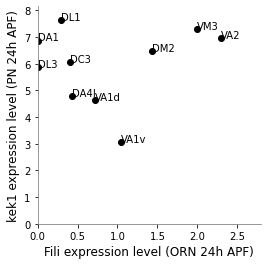

In [15]:
ORN=ORN_24h
PN=PN_24h
time = ['ORN 24h APF','PN 24h APF']
gene1='Fili'
gene2='kek1'
glom_list=gloms_shared
datatype_orn= [True,False]

fig, ax = plt.subplots(figsize =(4,4)) 

# calculate gene expression in each glom
PN_gene1 = PN[:, (PN.var_names == gene2)]
ORN_gene2 = ORN[:, (ORN.var_names == gene1)]
PN_gene1_mean = []
ORN_gene2_mean = []
glom_list_new = []
for glom_ in glom_list:
    PN_gene1_glom = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    ORN_gene2_glom = ORN_gene2[lr.get_glomtypes_from_seqss(ORN, True) == glom_]
    PN_mean=np.nanmean(PN_gene1_glom.X, axis=0)
    ORN_mean=np.nanmean(ORN_gene2_glom.X, axis=0)
    if math.isnan(PN_mean) == False and math.isnan(ORN_mean) == False:
        PN_gene1_mean.append(np.nanmean(PN_mean))
        ORN_gene2_mean.append(np.nanmean(ORN_mean))
        glom_list_new.append(glom_)

r = lr.Pearson_correlation(np.array(PN_gene1_mean), np.array(ORN_gene2_mean))
            
plt.scatter(ORN_gene2_mean, PN_gene1_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene2) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(ORN_gene2_mean)+0.5)
plt.ylim(0, max(PN_gene1_mean)+0.5)
#plt.title('r = : %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (ORN_gene2_mean[i], PN_gene1_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene2 + '_relationship_2.pdf')

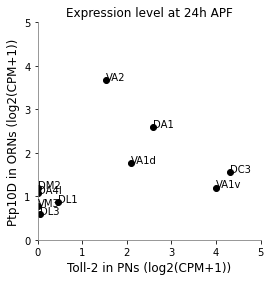

In [11]:
PN=PN_24h
ORN=ORN_24h
time = ['PN 24h APF','ORN 24h APF']
gene1='18w'
gene2='Ptp10D'
glom_list=gloms_shared
datatype_orn= [False,True]

fig, ax = plt.subplots(figsize =(4,4)) 

# calculate gene expression in each glom
PN_gene1 = PN[:, (PN.var_names == gene1)]
ORN_gene2 = ORN[:, (ORN.var_names == gene2)]
PN_gene1_mean = []
ORN_gene2_mean = []
glom_list_new = []
for glom_ in glom_list:
    PN_gene1_glom = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    ORN_gene2_glom = ORN_gene2[lr.get_glomtypes_from_seqss(ORN, True) == glom_]
    PN_mean=np.nanmean(PN_gene1_glom.X, axis=0)
    ORN_mean=np.nanmean(ORN_gene2_glom.X, axis=0)
    if math.isnan(PN_mean) == False and math.isnan(ORN_mean) == False:
        PN_gene1_mean.append(np.nanmean(PN_mean))
        ORN_gene2_mean.append(np.nanmean(ORN_mean))
        glom_list_new.append(glom_)

r = lr.Pearson_correlation(np.array(PN_gene1_mean), np.array(ORN_gene2_mean))
            
plt.scatter(PN_gene1_mean, ORN_gene2_mean, color = 'black')
plt.xlabel('Toll-2 in PNs (log2(CPM+1))', fontsize = 12)
plt.ylabel(str(gene2) + ' in ORNs (log2(CPM+1))', fontsize = 12)
#plt.xlim(0, max(PN_gene1_mean)+0.5)
#plt.ylim(0, max(ORN_gene2_mean)+0.5)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Expression level at 24h APF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (PN_gene1_mean[i], ORN_gene2_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene2 + '_relationship_1.pdf')

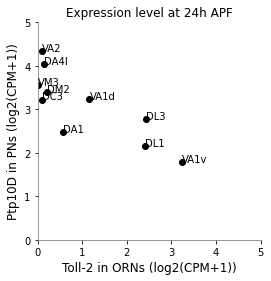

In [9]:
ORN=ORN_24h
PN=PN_24h
time = ['ORN 24h APF','PN 24h APF']
gene1='18w'
gene2='Ptp10D'
glom_list=gloms_shared
datatype_orn= [True,False]

fig, ax = plt.subplots(figsize =(4,4)) 

# calculate gene expression in each glom
PN_gene1 = PN[:, (PN.var_names == gene2)]
ORN_gene2 = ORN[:, (ORN.var_names == gene1)]
PN_gene1_mean = []
ORN_gene2_mean = []
glom_list_new = []
for glom_ in glom_list:
    PN_gene1_glom = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    ORN_gene2_glom = ORN_gene2[lr.get_glomtypes_from_seqss(ORN, True) == glom_]
    PN_mean=np.nanmean(PN_gene1_glom.X, axis=0)
    ORN_mean=np.nanmean(ORN_gene2_glom.X, axis=0)
    if math.isnan(PN_mean) == False and math.isnan(ORN_mean) == False:
        PN_gene1_mean.append(np.nanmean(PN_mean))
        ORN_gene2_mean.append(np.nanmean(ORN_mean))
        glom_list_new.append(glom_)

r = lr.Pearson_correlation(np.array(PN_gene1_mean), np.array(ORN_gene2_mean))
            
plt.scatter(ORN_gene2_mean, PN_gene1_mean, color = 'black')
plt.xlabel('Toll-2 in ORNs (log2(CPM+1))', fontsize = 12)
plt.ylabel(str(gene2) + ' in PNs (log2(CPM+1))', fontsize = 12)
#plt.xlim(0, max(ORN_gene2_mean)+0.5)
#plt.ylim(0, max(PN_gene1_mean)+0.5)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Expression level at 24h APF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (ORN_gene2_mean[i], PN_gene1_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene2 + '_relationship_2.pdf')

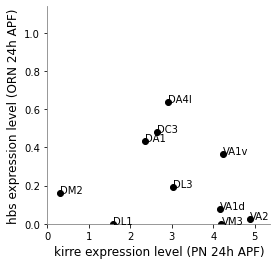

In [7]:
fig, ax = plt.subplots(figsize =(4,4)) 
plt.scatter(PN_gene1_mean, ORN_gene2_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene2) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(PN_gene1_mean)+0.5)
plt.ylim(0, max(ORN_gene2_mean)+0.5)
#plt.title('r = : %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (PN_gene1_mean[i], ORN_gene2_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene2 + '_relationship_1.png')

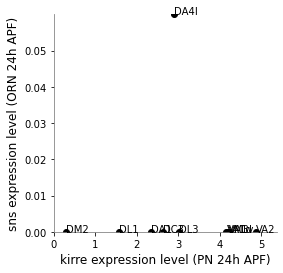

In [12]:
fig, ax = plt.subplots(figsize =(4,4)) 
plt.scatter(PN_gene1_mean, ORN_gene3_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene3) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(PN_gene1_mean)+0.5)
plt.ylim(0, max(ORN_gene3_mean))
#plt.title('r = : %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (PN_gene1_mean[i], ORN_gene3_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene3 + '_relationship_1.png')

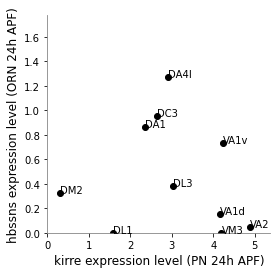

In [15]:
fig, ax = plt.subplots(figsize =(4,4)) 
plt.scatter(PN_gene1_mean, ORN_gene23_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene2) + str(gene3) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(PN_gene1_mean)+0.5)
plt.ylim(0, max(ORN_gene23_mean)+0.5)
#plt.title('r = : %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(PN_gene1_mean)):
    plt.annotate(glom_list_new[i], (PN_gene1_mean[i], ORN_gene23_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene3 + '_relationship_1.png')

In [26]:
#kirre
PN=PN_24h
ORN=ORN_24h
time = ['ORN 24h APF','PN 24h APF']
gene1='kirre'
gene2='hbs'
gene3='sns'
glom_list=gloms_shared
datatype_orn= [False,True]

# calculate gene expression in each glom
ORN_gene1 = ORN[:, (ORN.var_names == gene1)]
PN_gene2 = PN[:, (PN.var_names == gene2)]
PN_gene3 = PN[:, (PN.var_names == gene3)]
ORN_gene1_mean = []
ORN_gene1_mean_smaller = []
PN_gene2_mean = []
PN_gene3_mean = []
PN_gene23_mean = []
glom_list_new = []
for glom_ in glom_list:
    ORN_gene1_glom = ORN_gene1[lr.get_glomtypes_from_seqss(ORN, True) == glom_]
    PN_gene2_glom = PN_gene2[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    PN_gene3_glom = PN_gene3[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    ORN_mean=np.nanmean(ORN_gene1_glom.X, axis=0)
    PN_mean=np.nanmean(PN_gene2_glom.X, axis=0)
    PN_mean3=np.nanmean(PN_gene3_glom.X, axis=0)
    if math.isnan(PN_mean) == False and math.isnan(ORN_mean) == False:
        ORN_gene1_mean.append(np.nanmean(ORN_mean))
        ORN_gene1_mean_smaller.append(np.nanmean(ORN_mean-4)) #scale down kirre expression
        PN_gene2_mean.append(np.nanmean(PN_mean))
        PN_gene3_mean.append(np.nanmean(PN_mean3))
        PN_gene23_mean.append(np.nanmean(PN_mean) + np.nanmean(PN_mean3))
        glom_list_new.append(glom_)

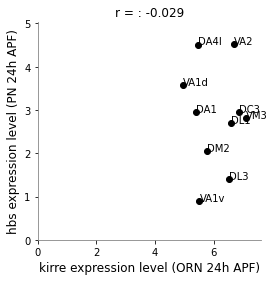

In [11]:
fig, ax = plt.subplots(figsize =(4,4)) 
plt.scatter(ORN_gene1_mean, PN_gene2_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene2) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(ORN_gene1_mean)+0.5)
plt.ylim(0, max(PN_gene2_mean)+0.5)
r = lr.Pearson_correlation(np.array(ORN_gene1_mean), np.array(PN_gene2_mean))
plt.title('r = : %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(ORN_gene1_mean)):
    plt.annotate(glom_list_new[i], (ORN_gene1_mean[i], PN_gene2_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene2 + '_relationship_1.pdf')

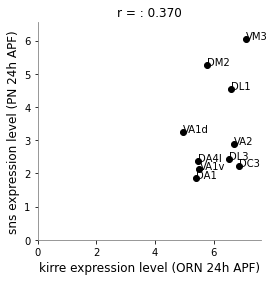

In [27]:
fig, ax = plt.subplots(figsize =(4,4)) 
plt.scatter(ORN_gene1_mean, PN_gene3_mean, color = 'black')
plt.xlabel(str(gene1) + ' expression level (' + time[0] + ')', fontsize = 12)
plt.ylabel(str(gene3) + ' expression level (' + time[1] + ')', fontsize = 12)
plt.xlim(0, max(ORN_gene1_mean)+0.5)
plt.ylim(0, max(PN_gene3_mean)+0.5)
r = lr.Pearson_correlation(np.array(ORN_gene1_mean), np.array(PN_gene3_mean))
plt.title('r = : %.3f' % r)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
for i in range(len(ORN_gene1_mean)):
    plt.annotate(glom_list_new[i], (ORN_gene1_mean[i], PN_gene3_mean[i]))
#plt.show()
plt.savefig('./stat/'+ gene1 + '_' + gene3 + '_relationship_1.pdf')

In [15]:
# data for 3D plot
PN=PN_24h
#time = ['PN 24h APF']
gene1='Fili'
gene2='18w'
gene3='hbs'
gene4='sns'
glom_list=gloms2
datatype_orn= False

# calculate gene expression in each glom
PN_gene1 = PN[:, (PN.var_names == gene1)]
PN_gene2 = PN[:, (PN.var_names == gene2)]
PN_gene3 = PN[:, (PN.var_names == gene3)]
PN_gene4 = PN[:, (PN.var_names == gene4)]
PN_gene1_mean = []
PN_gene2_mean = []
PN_gene3_mean = []
PN_gene4_mean = []
PN_gene34_mean = []
glom_list_new = []
for glom_ in glom_list:
    PN_gene1_glom = PN_gene1[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    PN_gene2_glom = PN_gene2[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    PN_gene3_glom = PN_gene3[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    PN_gene4_glom = PN_gene4[lr.get_glomtypes_from_seqss(PN, False) == glom_]
    PN_mean1=np.nanmean(PN_gene1_glom.X, axis=0)
    PN_mean2=np.nanmean(PN_gene2_glom.X, axis=0)
    PN_mean3=np.nanmean(PN_gene3_glom.X, axis=0)
    PN_mean4=np.nanmean(PN_gene4_glom.X, axis=0)
    PN_mean34=max(PN_mean3,PN_mean4)
    if math.isnan(PN_mean1) == False and math.isnan(PN_mean2) == False:
        PN_gene1_mean.append(np.nanmean(PN_mean1))
        PN_gene2_mean.append(np.nanmean(PN_mean2))
        PN_gene3_mean.append(np.nanmean(PN_mean3))
        PN_gene4_mean.append(np.nanmean(PN_mean4))
        PN_gene34_mean.append(np.nanmean(PN_mean34))
        glom_list_new.append(glom_)
data = {'glom':glom_list_new, 'Fili':PN_gene1_mean,'18w':PN_gene2_mean,'hbs-sns':PN_gene34_mean}
df = pd.DataFrame(data)
#df2 = pd.DataFrame({'glom':glom_list_new, 'Fili':PN_gene1_mean,'18w':PN_gene2_mean,'hbs':PN_gene3_mean,'sns':PN_gene4_mean,'hbs-sns':PN_gene34_mean})
#df2
df.to_excel('data3d.xlsx', index = False)

# Single manipulation penetrance

In [249]:
experiment = 'lof_fili_PN_kek1_ORN'

penetrance = [0*100, 16/30*100,14/26*100 , 9/22*100] #VA1d ORN into VA1v
phenotype_label = ['VA1v ORN into VA1d']
group_name = ['Wildtype','kek1 -/-', 'VA1v ORN >\n kek1 RNAi v36252', 'VA1v ORN >\n kek1 RNAi v101166']
experiment_code = ['-','BJ1','BE1','BE2']

In [257]:
experiment = 'kek1_sparse'

penetrance = [0, 14/16*100,6/16*100]
phenotype_label = ['VA1d ORN into VA1v and DA1']
group_name = ['Wildtype','VA1d ORN > kek1 OE','VA1d ORN Sparse > kek1 OE']
experiment_code = ['-','AN4','BD2']

In [7]:
experiment = 'lof_toll2_PN_ptp10D_ORN'

penetrance = [0*100, 8/18*100, (9+15)/(12+30)*100 , 3/12*100,8/29*100,9/20*100,6/10*100,20/34*100] #VA1d ORN into VA1v
phenotype_label = ['VA1d ORN into VA1v']
group_name = ['Wildtype', 'ptp10D -/-','VA1d ORN >\n ptp10D RNAi 39001', 'VA1d ORN >\n ptp10D RNAi v8010', 
              'Sparse VA1d ORN >\n ptp10D RNAi 39001','Toll2 +/-','VA1v PN >\n toll-2 RNAi 36305', 'VA1v PN >\n toll-2 RNAi 30498']
experiment_code = ['-','AB7','AX7,AN7','AN8','BD3','AG10','BA2','BA1']

In [11]:
experiment = 'lof_toll2_ORN_ptp10D_PN'

penetrance = [0*100, 7/14*100 , 8/18*100, 3/17*100,5/14*100,10/23*100] #VA1d ORN into VA1v
phenotype_label = ['VA1d PN into VA1v']
group_name = ['Wildtype','VA1d + DA1 PN >\n Ptp10D RNAi 39001', 'VA1d PN >\n Ptp10D RNAi 39001', 
              'VA1d PN >\n Ptp10D RNAi v8010', 'VA1v ORN >\n Toll2 RNAi 36305', 'VA1v ORN >\n Toll2 RNAi 30498']
experiment_code = ['-','AM18','AM11','AM12','BK2','BK3']

In [265]:
experiment = 'lof_hbssns_PN_kirre_ORN'

penetrance = [0*100, 8/12*100,9/12*100, 9/18*100,
              (6+8)/(8+14)*100, 4/10*100, 2/12*100 ,
              6/10*100,6/16*100,] #VA1d ORN into VA1v
phenotype_label = ['VA1v ORN into VA1d']
group_name = ['Wildtype', 'kirre -/-','VA1v ORN >\n kirre RNAi v109585', 'VA1v ORN >\n kirre RNAi v6696', 
              'hbs -/+','VA1d + DA1 PN >\n hbs RNAi 40898', 'VA1d + DA1 PN >\n hbs RNAi 105913', 
              'sns-/-','VA1d + DA1 PN >\n sns RNAi v109442',]
experiment_code = ['-','BJ1''BC1','BE4',
                   'BC2''BJ7','BE3','AE4',
                   'BJ6','AE5-2',]

In [25]:
experiment = 'screening'
penetrance = [0, 0, 0, 4/8*100, 7/7*100,5/8*100,9/12*100,8/12*100,14/20*100]
phenotype_label = ['mistargeting']
group_name = ['control','control','control','b','c','e','f','g','h']
experiment_code = []

In [5]:
experiment = 'kirreOE_DA4l'

penetrance = [0, 3/12*100]
phenotype_label = ['DA4l ORN mistargting']
group_name = ['Wildtype','DA4l ORN > kirre OE']
experiment_code = ['-','AZ6']

In [7]:
experiment = 'kirreOE_DA1'

penetrance = [0, 13/18*100]
phenotype_label = ['DA1 ORN into VA1v']
group_name = ['Wildtype','DA1 ORN > kirre OE']
experiment_code = ['-','AE6']

In [9]:
experiment = 'kek1RNAi_VM5v'

penetrance = [0, 4/14*100]
phenotype_label = ['VM5v PN mistarget']
group_name = ['Wildtype','pan-PN > kek1 RNAi 101166']
experiment_code = ['-','AT5']

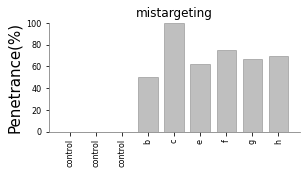

In [26]:
# plot piece

# set width of bar 
barWidth = 0.75
width = len(penetrance)*0.5

fig, ax = plt.subplots(figsize =(width, 2)) # chcange between 1 and 2 for different height

# Set position of bar on X axis 
br = np.arange(len(penetrance)) 
 
# Make the plot
plt.bar(br, penetrance, color ='grey', width = barWidth, 
        edgecolor ='grey', alpha=0.5) 
 
# Adding Xticks 
#plt.xlabel('Branch', fontsize = 15) #fontweight ='bold'
plt.ylabel('Penetrance(%)',  fontsize = 15) 
plt.xticks([r for r in range(len(penetrance))], 
        group_name,  rotation=90)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylim((0,100))
plt.title(phenotype_label[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

#plt.show()
plt.savefig('./stat/'+experiment+'.pdf',dpi=300)

# Mistarget ratio

Information for drawing mask:

using NCad to draw make for glomeruli


In [3]:
# kirre
experiment = 'kirre_dual_manipulation_mistarget_ratio_total.pdf'
experiment_name = ['Control','BC9', 'BC17', 'BC18', 'BC16','BC7'] 
genotype = ['Control','sns+/+ \nhbs+/+','sns-/- \nhbs+/+', 'sns+/+ \nhbs-/+', 'sns-/- \nhbs-/+','kirre-/-'] #add /n to make it into two lines
control_zero = len([1,1,3,3,4,4,5,5,])
half_brain_zero = [control_zero,0, 0,0,0,0]
ch_pn_list = [1,0,1,1,1,0]

In [12]:
# fili kek1
# gausiaan filter d=1
experiment = 'kek1_dual_manipulation_mistarget_ratio_total.pdf'
experiment_name = ['Control','AQ1','AN4','AQ2','AQ3'] 
genotype = ['Control','Fili-/-','VA1d ORN > kek1 OE', 'VA1d ORN > kek1 OE\nFili-/+', 'VA1d ORN > kek1 OE\nFili-/-'] #add /n to make it into two lines
control_zero = len([1,1,3,3,4,4,5,5,])
AQ1_zero = len([1,1,3,3])
AQ2_zero = len([8,9,9,10,10,11,12,12,13])
AQ3_zero = len([1,2,3,6,6, 7,7,8,8])
half_brain_zero = [control_zero,  AQ1_zero,0,AQ2_zero,AQ3_zero]
ch_pn_list = [1,0,0,0,0]

In [13]:
# figure for VA1d into DA1/VA1v
# ratio of VA1d ORN mistarget into VA1v and DA1 - area with thresholding
folder_0 = './mistarget/'
DA1_to_VA1d_area_all = []
VA1v_to_VA1d_area_all = []
mis_VA1d_area_all = []
for i in range(len(genotype)):
    recs = lr.get_recs_ORN_label(experiment_name[i], folder_0)
    DA1_to_VA1d_area = []
    VA1v_to_VA1d_area = []
    mis_VA1d_area = []
    for rec in recs:
        print(rec.fn)
        for side in range(2):
            if rec.area_VA1d[side]>0:
                DA1_to_VA1d_area.append(rec.area_DA1[side]/rec.area_VA1d[side])
                VA1v_to_VA1d_area.append(rec.area_VA1v[side]/rec.area_VA1d[side])
                mis_VA1d_area.append((rec.area_DA1[side]+rec.area_VA1v[side])/rec.area_VA1d[side])
    for n in range(half_brain_zero[i]):
        mis_VA1d_area.append(0)
    DA1_to_VA1d_area_all.append(DA1_to_VA1d_area)
    VA1v_to_VA1d_area_all.append(VA1v_to_VA1d_area)
    mis_VA1d_area_all.append(mis_VA1d_area)

.//./mistarget/Control_d_d_Cross0d_w1118-2-VA1d.nrrd
.//./mistarget/Control_TT-VA1d_VA1d-w1118-9-VA1d.nrrd
.//./mistarget/Control_TT-VA1d_VA1d-w1118-10-VA1d.nrrd
.//./mistarget/Control_TT-VA1d_VA1d-w1118-7-VA1d.nrrd
.//./mistarget/AQ10-8_20240605_40X_16-VA1d.nrrd
.//./mistarget/AQ10-8_20240605_40X_17-VA1d.nrrd
.//./mistarget/AQ1_20230503_20X_2-VA1d.nrrd
.//./mistarget/AQ10-8_20231002_20X_4-VA1d.nrrd
.//./mistarget/AQ11_20240605_40X_6-VA1d.nrrd
.//./mistarget/AN4_20230508_20X_6-VA1d.nrrd
.//./mistarget/AN4_20230508_20X_7-VA1d.nrrd
.//./mistarget/AN4_20230508_20X_5-VA1d.nrrd
.//./mistarget/AN4_20230508_20X_1-VA1d.nrrd
.//./mistarget/AN4_20230508_20X_3-VA1d.nrrd
.//./mistarget/AN4_20230508_20X_8-VA1d.nrrd
.//./mistarget/AQ2_20230502_20X_6-VA1d.nrrd
.//./mistarget/AQ2_20230502_20X_7-VA1d.nrrd
.//./mistarget/AQ2_20230426_20X_1-VA1d.nrrd
.//./mistarget/AQ2_20230503_20X_13-VA1d.nrrd
.//./mistarget/AQ2_20230503_20X_11-VA1d.nrrd
.//./mistarget/AQ3_20230503_20X_2-VA1d.nrrd
.//./mistarget/AQ3_202

Control n = 15
Fili-/- n = 11
VA1d ORN > kek1 OE n = 11
VA1d ORN > kek1 OE
Fili-/+ n = 15
VA1d ORN > kek1 OE
Fili-/- n = 12


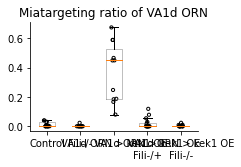

In [14]:
# plot - area with thresholding
#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 2)) 

# Creating plot
bp1 = ax.boxplot(mis_VA1d_area_all, showfliers = False, 
                 #whiskerprops={'color': 'white', 'linewidth': 0},
                 boxprops={'color': 'grey', 'linewidth': 0.5},
                 meanprops={'color': 'r', 'linestyle': '--', 'linewidth': 2})
ax.set_xticklabels(genotype)  # Set the labels for the x ticks
ax.set_title('Miatargeting ratio of VA1d ORN')

ave = []
for i in range(len(genotype)):
    ave.append(np.mean(mis_VA1d_area_all[i]))
    y = []
    for j in range(len(mis_VA1d_area_all[i])):
        y.append(mis_VA1d_area_all[i][j])
    x1 = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x1, y, s=10,facecolors='none', edgecolors='black')

for i in range(len(genotype)):
    print(genotype[i],'n =',len(mis_VA1d_area_all[i]))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()
plt.savefig('./stat/'+experiment, dpi=300)

In [75]:
# Kruskal-Wallis test
H_statistic, p_value = stats.kruskal(*mis_VA1d_area_all)
print(f"Kruskal-Wallis test statistic: {H_statistic}, p-value: {p_value}")

# If the Kruskal-Wallis test is significant, perform the multiple comparison (Bonferroni correction)
if p_value < 0.05:
    # Combine the data into a single array
    all_data = np.concatenate(mis_VA1d_area_all)
    
    # Create an array of group labels
    labels = []
    for i in range(len(genotype)):
        labels += [experiment_name[i]]*len(mis_VA1d_area_all[i])
    #labels = ['Group 1']*len(data[0]) + ['Group 2']*len(data[1]) + ['Group 3']*len(data[2]) + \
             #['Group 4']*len(data[3]) + ['Group 5']*len(data[4])
    
    # Perform pairwise comparison with Bonferroni correction using Tukey's HSD test
    comparison = pairwise_tukeyhsd(all_data, labels, alpha=0.05)
    print(comparison)
else:
    print("The Kruskal-Wallis test is not significant, so multiple comparisons are not necessary.")

Kruskal-Wallis test statistic: 41.53180955717079, p-value: 7.325710763238194e-08
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
  BC16    BC17   0.0622 0.4883 -0.0409  0.1652  False
  BC16    BC18   0.0668 0.3589 -0.0319  0.1654  False
  BC16     BC7   0.1981    0.0  0.0951  0.3012   True
  BC16     BC9   0.1755 0.0002  0.0662  0.2848   True
  BC16 Control  -0.0144 0.9975 -0.1085  0.0797  False
  BC17    BC18   0.0046    1.0 -0.0941  0.1033  False
  BC17     BC7    0.136 0.0034  0.0329   0.239   True
  BC17     BC9   0.1133 0.0379   0.004  0.2226   True
  BC17 Control  -0.0766 0.1738 -0.1707  0.0175  False
  BC18     BC7   0.1314  0.003  0.0327  0.2301   True
  BC18     BC9   0.1087 0.0388  0.0035  0.2139   True
  BC18 Control  -0.0812  0.095 -0.1704  0.0081  False
   BC7     BC9  -0.0226 0.9899  -0.132  0.0867  False
   BC7 Control  -0.2126    0.0 -0.3066 -0.1185   True
 

In [85]:
# Shapiro-Wilk test for normality
statistic, p_value = stats.shapiro(mis_VA1d_area_all[4])

# Print the result
print(f"Shapiro-Wilk Test Statistic: {statistic}")
print(f"P-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.7948931455612183
P-value: 0.012567178346216679


For all tests, if the p-value is greater than 0.05, you do not reject the null hypothesis (i.e., the data is normally distributed). If the p-value is less than 0.05, you reject the null hypothesis (i.e., the data does not follow a normal distribution).

In [15]:
# ptp10d 18w, into DA4l
# gausiaan filter d=1
experiment = '18w_dual_manipulation_mistarget_ratio_total.pdf'
genotype = ['Control','VA1d ORN > 18w OE', 'Ptp10D -/Y ', 'VA1d ORN > 18w OE \n Ptp10D -/Y']
experiment_name = ['ControlPN','AQ9','AQ11','AQ10',] 
#AQ10-8 COUNT 0: 
control_zero = len([1,2,3,4,5,7,8,10,11,12,13])
AQ10_zero = len([7,7,9,11,12,13,14,15,18])
AQ11_zero = len([1,3,4,5,7,8,9,10,11])
half_brain_zero = [control_zero,0,AQ11_zero,AQ10_zero]
ch_pn_list = [1,3,0,0]


In [16]:
# figure for VA1d into DA4l
# ratio of VA1d ORN mistarget into VA1v and DA1 - area with thresholding
folder_0 = './mistarget/'
DA4l_to_VA1d_area_all = []
for i in range(len(genotype)):
    recs = lr.get_recs_ORN_label(experiment_name[i], folder_0)
    DA4l_to_VA1d_area = []
    for rec in recs:
        print(rec.fn)
        for side in range(2):
            if rec.area_VA1d[side]>0:
                DA4l_to_VA1d_area.append(rec.area_DA4l[side]/rec.area_VA1d[side])
    for n in range(half_brain_zero[i]):
        DA4l_to_VA1d_area.append(0)
    DA4l_to_VA1d_area_all.append(DA4l_to_VA1d_area)

.//./mistarget/AQ9_20231002_20X_2good-VA1d.nrrd
.//./mistarget/AQ9_20231002_20X_8good-VA1d.nrrd
.//./mistarget/AQ9_AN18_20230815_20x_4-VA1d.nrrd
.//./mistarget/AQ9_AN18_20230815_20x_7-VA1d.nrrd
.//./mistarget/AQ9_20231002_20X_9good-VA1d.nrrd
.//./mistarget/AQ9_20231002_20X_4good-VA1d.nrrd
.//./mistarget/AQ9_AN18_20230815_20x_8-VA1d.nrrd
.//./mistarget/AQ9_20231002_20X_6good-VA1d.nrrd
.//./mistarget/AQ9_20231002_20X_10good-VA1d.nrrd
.//./mistarget/AQ9_20231002_20X_7good-VA1d.nrrd
.//./mistarget/AQ11_20240605_40X_6-VA1d.nrrd
.//./mistarget/AQ10-8_20240605_40X_16-VA1d.nrrd
.//./mistarget/AQ10-8_20240605_40X_17-VA1d.nrrd
.//./mistarget/AQ10-8_20231002_20X_4-VA1d.nrrd


Control n = 11
VA1d ORN > 18w OE n = 11
Ptp10D -/Y  n = 10
VA1d ORN > 18w OE 
 Ptp10D -/Y n = 14


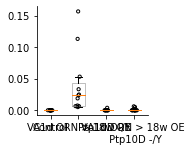

In [21]:
# plot - area with thresholding
#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(figsize = (2, 2)) 

# Creating plot
bp1 = ax.boxplot(DA4l_to_VA1d_area_all,showfliers=False,
                 #whiskerprops={'color': 'white', 'linewidth': 0},
                 boxprops={'color': 'grey', 'linewidth': 0.5},
                 meanprops={'color': 'r', 'linestyle': '--', 'linewidth': 2})
ax.set_xticklabels(genotype)  # Set the labels for the x ticks
#ax.set_title('Miatargeting ratio of VA1d PN')

ave = []
for i in range(len(genotype)):
    ave.append(np.mean(DA4l_to_VA1d_area_all[i]))
    y = []
    for j in range(len(DA4l_to_VA1d_area_all[i])):
        y.append(DA4l_to_VA1d_area_all[i][j])
    x1 = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x1, y, s=10,facecolors='none', edgecolors='black')

for i in range(len(genotype)):
    print(genotype[i],'n =',len(DA4l_to_VA1d_area_all[i]))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()
plt.savefig('./stat/' + experiment + '.pdf', dpi=300)

In [61]:
# Kruskal-Wallis test
H_statistic, p_value = stats.kruskal(*DA4l_to_VA1d_area_all)
print(f"Kruskal-Wallis test statistic: {H_statistic}, p-value: {p_value}")

# If the Kruskal-Wallis test is significant, perform the multiple comparison (Bonferroni correction)
if p_value < 0.05:
    # Combine the data into a single array
    all_data = np.concatenate(DA4l_to_VA1d_area_all)
    
    # Create an array of group labels
    labels = []
    for i in range(len(genotype)):
        labels += [experiment_name[i]]*len(DA4l_to_VA1d_area_all[i])
    #labels = ['Group 1']*len(data[0]) + ['Group 2']*len(data[1]) + ['Group 3']*len(data[2]) + \
             #['Group 4']*len(data[3]) + ['Group 5']*len(data[4])
    
    # Perform pairwise comparison with Bonferroni correction using Tukey's HSD test
    comparison = pairwise_tukeyhsd(all_data, labels, alpha=0.05)
    print(comparison)
else:
    print("The Kruskal-Wallis test is not significant, so multiple comparisons are not necessary.")

Kruskal-Wallis test statistic: 35.44692633000052, p-value: 9.80162833265105e-08
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
  AQ10      AQ11  -0.0006 0.9999 -0.0274  0.0263  False
  AQ10       AQ9   0.0399 0.0011  0.0138   0.066   True
  AQ10 ControlPN  -0.0009 0.9997 -0.0271  0.0252  False
  AQ11       AQ9   0.0404 0.0024  0.0121  0.0687   True
  AQ11 ControlPN  -0.0004    1.0 -0.0287  0.0279  False
   AQ9 ControlPN  -0.0408 0.0016 -0.0684 -0.0132   True
-------------------------------------------------------


In [23]:
# ptp10d 18w, into DC3
# gausiaan filter d=1
experiment = '18w_cell_type_specific_transcellular.pdf'
genotype = ['Control','VA1d ORN > 18w OE', 'VA1d PN > PTP10d RNAi ', 'VA1d ORN > 18w OE \n VA1d PN > PTP10d RNAi']
experiment_name = ['BM2','BM6','BM7','BM8-2'] 
BM2_zero = len([9,9,8,7,6,5,5,3,3,2,1])
BM7_zero = len([9,9,8,8,7,7,3,3,2,2])
half_brain_zero = [BM2_zero,0,BM7_zero,0]
ch_pn_list = [1,1,1,1]

In [24]:
# figure for cell-type-specific transcellular assay
# ratio of VA1d ORN mistarget into DC3 - area with thresholding
folder_0 = './mistarget/'
DC3_to_VA1d_area_all = []
DC3_to_both_area_all = []
for i in range(len(genotype)):
    recs = lr.get_recs_ORN_label(experiment_name[i], folder_0)
    DC3_to_VA1d_area = []
    DC3_to_both_area = []
    for rec in recs:
        print(rec.fn)
        for side in range(2):
            if rec.area_VA1d[side]>0:
                DC3_to_VA1d_area.append(rec.area_DC3[side]/rec.area_VA1d[side])
                DC3_to_both_area.append(rec.area_DC3[side]/rec.area_total[side])
    for n in range(half_brain_zero[i]):
        DC3_to_VA1d_area.append(0)
        DC3_to_both_area.append(0)
    DC3_to_VA1d_area_all.append(DC3_to_VA1d_area)
    DC3_to_both_area_all.append(DC3_to_both_area)

.//./mistarget/BM2(splitPN)_20241223_20X_4-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_20-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_22-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_23-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_18-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_19-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_3-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_4-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_16-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_13-VA1d.nrrd
.//./mistarget/BM6(splitPN)_20241209_20X_11-VA1d.nrrd
.//./mistarget/BM7(splitPN)_20241229_20X_12(mis)-VA1d.nrrd
.//./mistarget/BM7(splitPN)_20241229_20X_1-VA1d.nrrd
.//./mistarget/BM8-2(splitPN)_20241209_20X_5-VA1d.nrrd
.//./mistarget/BM8-2(splitPN)_20241209_20X_7-VA1d.nrrd
.//./mistarget/BM8-2(splitPN)_20241209_20X_6-VA1d.nrrd
.//./mistarget/BM8-2(splitPN)_20241209_20X_3-VA1d.nrrd
.//./mistarget/BM8-2(splitPN)_20241209_20X_1-VA1d.nrrd
.//./mistarget/BM8-2(s

Control n = 11 0.0
VA1d ORN > 18w OE n = 13 0.41650917579168467
VA1d PN > PTP10d RNAi  n = 13 0.0012480331523282563
VA1d ORN > 18w OE 
 VA1d PN > PTP10d RNAi n = 11 0.08596167630549066


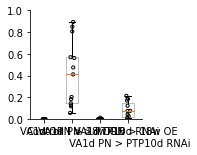

In [25]:
# plot - area with thresholding
#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(figsize = (2, 2)) 

# Creating plot
bp1 = ax.boxplot(DC3_to_both_area_all,showfliers=False,
                 #whiskerprops={'color': 'white', 'linewidth': 0},
                 boxprops={'color': 'grey', 'linewidth': 0.5},
                 meanprops={'color': 'r', 'linestyle': '--', 'linewidth': 2})
ax.set_xticklabels(genotype)  # Set the labels for the x ticks
#ax.set_title('Miatargeting ratio of VA1d PN')
plt.ylim(0,1)

ave = []
for i in range(len(genotype)):
    ave.append(np.mean(DC3_to_both_area_all[i]))
    y = []
    for j in range(len(DC3_to_both_area_all[i])):
        y.append(DC3_to_both_area_all[i][j])
    x1 = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x1, y, s=10,facecolors='none', edgecolors='black')

for i in range(len(genotype)):
    print(genotype[i],'n =',len(DC3_to_both_area_all[i]), ave[i])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()
plt.savefig('./stat/' + experiment + '.pdf', dpi=300)

In [57]:
# Kruskal-Wallis test
H_statistic, p_value = stats.kruskal(*DC3_to_both_area_all)
print(f"Kruskal-Wallis test statistic: {H_statistic}, p-value: {p_value}")

# If the Kruskal-Wallis test is significant, perform the multiple comparison (Bonferroni correction)
if p_value < 0.05:
    # Combine the data into a single array
    all_data = np.concatenate(DC3_to_both_area_all)
    
    # Create an array of group labels
    labels = []
    for i in range(len(genotype)):
        labels += [experiment_name[i]]*len(DC3_to_both_area_all[i])
    #labels = ['Group 1']*len(data[0]) + ['Group 2']*len(data[1]) + ['Group 3']*len(data[2]) + \
             #['Group 4']*len(data[3]) + ['Group 5']*len(data[4])
    
    # Perform pairwise comparison with Bonferroni correction using Tukey's HSD test
    comparison = pairwise_tukeyhsd(all_data, labels, alpha=0.05)
    print(comparison)
else:
    print("The Kruskal-Wallis test is not significant, so multiple comparisons are not necessary.")

Kruskal-Wallis test statistic: 41.12743498619912, p-value: 6.144632035438994e-09
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   BM2    BM6   0.4165    0.0  0.2397  0.5934   True
   BM2    BM7   0.0012    1.0 -0.1756  0.1781  False
   BM2  BM8-2    0.086 0.6009 -0.0981    0.27  False
   BM6    BM7  -0.4153    0.0 -0.5846 -0.2459   True
   BM6  BM8-2  -0.3305 0.0001 -0.5074 -0.1537   True
   BM7  BM8-2   0.0847 0.5809 -0.0921  0.2616  False
----------------------------------------------------
